In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor
import os
import os, glob, re
import torch
import numpy as np
import imageio.v3 as iio
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Dataset


In [2]:
# # -------------------------------
# # Autoencoder
# # -------------------------------
# class ReflectanceAutoEncoder(nn.Module):
#     def __init__(self, latent_dim=32):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(3, 32),
#             nn.ReLU(),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, latent_dim),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 16),
#             nn.ReLU(),
#             nn.Linear(16, 32),
#             nn.ReLU(),
#             nn.Linear(32, 3),
#         )

#     def forward(self, x):
#         B, N, C = x.shape
#         x = x.view(-1, C)
#         z = self.encoder(x)
#         out = self.decoder(z)
#         return out.view(B, N, C)


# # -------------------------------
# # Training helpers
# # -------------------------------
# def train_batch(model, optimizer, loss_fn, batch):
#     optimizer.zero_grad()
#     recon = model(batch)
#     loss = loss_fn(recon, batch)
#     loss.backward()
#     optimizer.step()
#     return loss.item()


# def train(model, data, batch_size=1000, epochs=5, lr=1e-3, device=None):
#     device = device or ("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
#     data = data.to(device)

#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     loss_fn = nn.MSELoss()

#     B, N, _ = data.shape
#     for epoch in range(epochs):
#         perm = torch.randperm(N, device=device)
#         total_loss = 0.0

#         for i in range(0, N, batch_size):
#             idx = perm[i:i + batch_size]
#             batch = data[:, idx, :]
#             loss = train_batch(model, optimizer, loss_fn, batch)
#             total_loss += loss

#         avg_loss = total_loss / (N // batch_size)
#         print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.6f}")


# # -------------------------------
# # Example usage
# # -------------------------------
# H, W = 10, 10
# data = torch.rand(H * W, 2048, 3)  # multiple images

# model = ReflectanceAutoEncoder(latent_dim=32)
# train(model, data, batch_size=10, epochs=10)


In [3]:

# # -------------------------------
# # Simple Autoencoder
# # -------------------------------
# class ReflectanceAutoEncoder(nn.Module):
#     def __init__(self, latent_dim=32):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(3, 32), nn.ReLU(),
#             nn.Linear(32, 16), nn.ReLU(),
#             nn.Linear(16, latent_dim)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 16), nn.ReLU(),
#             nn.Linear(16, 32), nn.ReLU(),
#             nn.Linear(32, 3)
#         )

#     def forward(self, x):
#         B, N, C = x.shape
#         x = x.view(-1, C)
#         z = self.encoder(x)
#         out = self.decoder(z)
#         return out.view(B, N, C)


# # -------------------------------
# # Training functions
# # -------------------------------
# def train_batch(model, optimizer, loss_fn, batch):
#     optimizer.zero_grad()
#     recon = model(batch)
#     loss = loss_fn(recon, batch)
#     loss.backward()
#     optimizer.step()
#     return loss.item()


# def train(model, dataloader, epochs=5, lr=1e-3, device=None):
#     device = device or ("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     loss_fn = nn.MSELoss()

#     for epoch in range(epochs):
#         total_loss = 0.0
#         for batch in dataloader:
#             batch = batch.to(device)
#             loss = train_batch(model, optimizer, loss_fn, batch)
#             total_loss += loss
#         avg_loss = total_loss / len(dataloader)
#         print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {avg_loss:.6f}")


# # -------------------------------
# # Example config & run
# # -------------------------------
# config = {
#     "row_slice": [150, 160],
#     "col_slice": [150, 160],
#     "mask_path": "/home/gmh72/3DReconstruction/Blender_Rendering/data/diffuse_suzanne_white/mask.png",  # any grayscale mask image
#     "reflectance_data_dir": "/home/gmh72/3DReconstruction/Blender_Rendering/data/diffuse_suzanne_white/reflectance"
# }

# # Create dataset and dataloader
# dataset = ReflectanceDataset(config)
# dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# # Train model
# # model = ReflectanceAutoEncoder()
# # train(model, dataloader, epochs=5)


In [2]:
# Load trained model weights
class ReflectanceAutoEncoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2048 * 3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048 * 3),
        )

    def forward(self, x):
        # x: (B, 2048, 3)
        B = x.shape[0]
        x = x.view(B, -1)          # flatten reflectance map
        z = self.encoder(x)        # (B, latent_dim)
        out = self.decoder(z)      # (B, 2048*3)
        return out.view(B, 2048, 3), z
model = ReflectanceAutoEncoder(latent_dim=64)
model.load_state_dict(torch.load("/home/gmh72/3DReconstruction/2DRelighting/output/auto/reflectance_autoencoder.pth", map_location="cuda"))
model.eval().to("cuda")

# Extract just the decoder
decoder = model.decoder
decoder.eval()
latent_dim = 64
z_p = torch.randn(1, latent_dim).to("cuda")
refl = decoder(z_p).view(1, 2048, 3).detach().cpu().numpy()  # shape (1, 2048, 3)

/tmp/ipykernel_3818399/1587622760.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/gmh72/3DReconstruction/2DRelighting/output/aut

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=6144, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


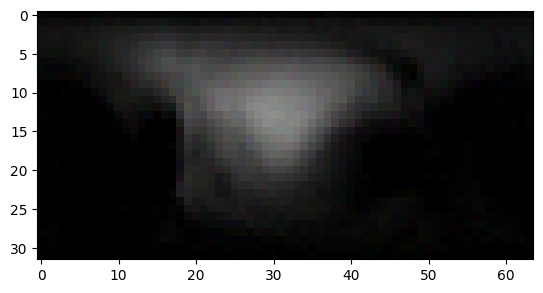

In [11]:
# Example: random latent vector
latent_dim = 64
z_p = torch.randn(1, latent_dim).to("cuda")
refl = decoder(z_p).view(1, 2048, 3).detach().cpu().numpy()  # shape (1, 2048, 3)
# z.shape
# Decode to RGB reflectance
# reflectance = decoder(z).view(B, N, 3).detach().cpu().numpy()  # shape (1, 2048, 3)
refl = decoder(z_p).view(1, 2048, 3).detach().cpu().numpy()  # shape (1, 2048, 3)
import matplotlib.pyplot as plt
plt.imshow(refl[0].reshape(32, 64,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


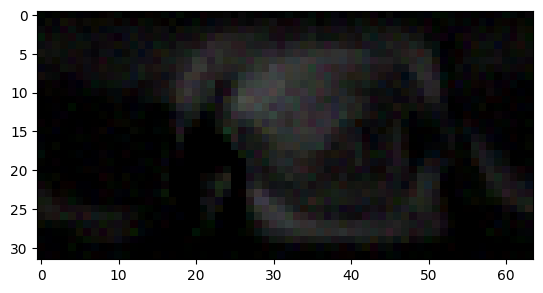

In [4]:
import matplotlib.pyplot as plt
plt.imshow(refl[0].reshape(32, 64,3))

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# -------------------------------
# Building Blocks
# -------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# -------------------------------
# UNet Autoencoder with Latent Vector
# -------------------------------
class UNetAutoEncoder(nn.Module):
    def __init__(self, in_channels=64, out_channels=64, latent_dim=128, H=64, W=64):
        super().__init__()
        self.H, self.W = H, W

        # Encoder
        self.inc = DoubleConv(in_channels, 32)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))

        # Latent bottleneck
        flattened_size = 256 * (H // 8) * (W // 8)
        self.to_latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, latent_dim),
            nn.ReLU(inplace=True)
        )

        self.from_latent = nn.Sequential(
            nn.Linear(latent_dim, flattened_size),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(64, 32)
        self.outc = nn.Conv2d(32, out_channels, kernel_size=1)

    # Full encode + decode
    def forward(self, x):
        z = self.encode(x)
        out = self.decode(z)
        return out, z

    # Encoder only
    def encode(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        z = self.to_latent(x4)
        return z

    # Decoder only
    def decode(self, z):
        B = z.shape[0]
        x = self.from_latent(z)
        x = x.view(B, 256, self.H // 8, self.W // 8)
        x = self.up1(x)
        x = self.conv1(torch.cat([x, torch.zeros_like(x)], dim=1))  # simplified skip
        x = self.up2(x)
        x = self.conv2(torch.cat([x, torch.zeros_like(x)], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, torch.zeros_like(x)], dim=1))
        return self.outc(x)

# -------------------------------
# Demo Dataset Generator
# -------------------------------
def generate_random_reflectance_dataset(num_samples=4, C=64, H=64, W=64):
    data = torch.rand(num_samples, C, H, W)
    dataset = TensorDataset(data, data)
    return DataLoader(dataset, batch_size=1, shuffle=True)

# -------------------------------
# Training Loop
# -------------------------------
def train_autoencoder(model, dataloader, epochs=5, lr=1e-3, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred, z = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {total_loss/len(dataloader):.6f}")

    return model




In [7]:
# -------------------------------
# Run Example
# -------------------------------
if __name__ == "__main__":
    dataloader = generate_random_reflectance_dataset(num_samples=4, C=64, H=64, W=64)
    model = UNetAutoEncoder(in_channels=64, out_channels=64, latent_dim=128, H=64, W=64)
    trained_model = train_autoencoder(model, dataloader, epochs=5)


Epoch 1/5 | Avg Loss: 0.451896
Epoch 2/5 | Avg Loss: 0.349106
Epoch 3/5 | Avg Loss: 0.285733
Epoch 4/5 | Avg Loss: 0.246154
Epoch 5/5 | Avg Loss: 0.219627


In [15]:

# Example: Get latent and reconstruct
sample = next(iter(dataloader))[0].to("cuda")
z = trained_model.encode(sample)
recon = trained_model.decode(z)
print(f"Latent vector shape: {z.shape}")
print(f"Reconstructed reflectance shape: {recon.shape}")

Latent vector shape: torch.Size([1, 128])
Reconstructed reflectance shape: torch.Size([1, 64, 64, 64])


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------------
# UNet Encoder (spatial structure)
# ---------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNetEncoder(nn.Module):
    def __init__(self, in_channels=64, latent_dim=128, H=64, W=64):
        super().__init__()
        self.inc = DoubleConv(in_channels, 32)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        flattened_size = 256 * (H // 8) * (W // 8)
        self.fc = nn.Linear(flattened_size, latent_dim)

    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = x.flatten(1)
        z = self.fc(x)
        return z

# ---------------------------------
# MLP Decoder (per-pixel reflectance)
# ---------------------------------
class ReflectanceDecoder(nn.Module):
    def __init__(self, latent_dim=128, out_channels=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, out_channels)
        )

    def forward(self, z):
        out = self.net(z)                   # (B, out_channels)
        return out.view(z.size(0), -1, 1, 1)  # (B, C, 1, 1)

# ---------------------------------
# Hybrid Model (Encoder + Decoder)
# ---------------------------------
class HybridReflectanceModel(nn.Module):
    def __init__(self, in_channels=64, latent_dim=128, out_channels=64, H=64, W=64):
        super().__init__()
        self.encoder = UNetEncoder(in_channels, latent_dim, H, W)
        self.decoder = ReflectanceDecoder(latent_dim, out_channels)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

# ---------------------------------
# Dummy Reflectance Dataset
# ---------------------------------
def generate_random_reflectance_dataset(num_samples=4, C=64, H=64, W=64):
    data = torch.rand(num_samples, C, H, W)
    dataset = TensorDataset(data, data.mean(dim=[2,3], keepdim=True))  
    # Target = mean reflectance vector per pixel (for demo)
    return DataLoader(dataset, batch_size=1, shuffle=True)

# ---------------------------------
# Training Loop
# ---------------------------------
def train_hybrid(model, dataloader, epochs=5, lr=1e-3, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred, z = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {total_loss/len(dataloader):.6f}")
    return model




In [18]:
# ---------------------------------
# Run Demo
# ---------------------------------
if __name__ == "__main__":
    dataloader = generate_random_reflectance_dataset(num_samples=4, C=64, H=64, W=64)
    model = HybridReflectanceModel(in_channels=64, latent_dim=128, out_channels=64, H=64, W=64)
    trained_model = train_hybrid(model, dataloader, epochs=5)

    # Test: generate reflectance for a pixel
    x = torch.rand(1, 64, 64, 64).to("cuda")
    z = trained_model.encoder(x)
    reflectance = trained_model.decoder(z)
    print(f"Latent shape: {z.shape}, Reflectance shape: {reflectance.shape}")

Epoch 1/5 | Avg Loss: 0.173872
Epoch 2/5 | Avg Loss: 0.137358
Epoch 3/5 | Avg Loss: 0.083859
Epoch 4/5 | Avg Loss: 0.062556
Epoch 5/5 | Avg Loss: 0.030633
Latent shape: torch.Size([1, 128]), Reflectance shape: torch.Size([1, 64, 1, 1])


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# --------------------------------------------------
# Double Conv block
# --------------------------------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

# --------------------------------------------------
# Encoder
# --------------------------------------------------
class UNetEncoder(nn.Module):
    def __init__(self, in_channels=96, latent_dim=128):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, latent_dim)
        # self.down_factor = down_factor  # keep for reference

    def forward(self, x):
        # 4× maxpools → total downsample factor 16
        e1 = self.enc1(x)
        p1 = F.max_pool2d(e1, 2)
        e2 = self.enc2(p1)
        p2 = F.max_pool2d(e2, 2)
        e3 = self.enc3(p2)
        p3 = F.max_pool2d(e3, 2)
        z = F.max_pool2d(self.enc4(p3), 2)  # (N, latent_dim, H//16, W//16)
        return z

# --------------------------------------------------
# Decoder
# --------------------------------------------------
class UNetDecoder(nn.Module):
    def __init__(self, out_channels=96, latent_dim=128):
        super().__init__()
        self.up4 = nn.ConvTranspose2d(latent_dim, 256, 2, stride=2)
        self.dec4 = DoubleConv(256, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(128, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(64, 64)
        self.up1 = nn.ConvTranspose2d(64, out_channels, 2, stride=2)

    def forward(self, z):
        d4 = self.up4(z)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = self.dec2(d2)
        out = self.up1(d2)
        return out

# --------------------------------------------------
# Combined Autoencoder
# --------------------------------------------------
class ReflectanceAutoEncoder(nn.Module):
    def __init__(self, in_channels=96, latent_dim=128):
        super().__init__()
        self.encoder = UNetEncoder(in_channels, latent_dim)
        self.decoder = UNetDecoder(in_channels, latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

# --------------------------------------------------
# Dummy Data
# --------------------------------------------------
def get_random_dataloader(N=4, C=96, H=400, W=400, batch_size=1):
    data = torch.rand(N, C, H, W)
    ds = TensorDataset(data, data)
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

# --------------------------------------------------
# Train Loop
# --------------------------------------------------
def train_autoencoder(model, dataloader, epochs=3, lr=1e-3, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            recon, z = model(x)
            loss = loss_fn(recon, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {total_loss/len(dataloader):.6f}")

    # test one batch
    x, _ = next(iter(dataloader))
    x = x.to(device)
    z = model.encoder(x)
    recon = model.decoder(z)
    print("\nEncoder/Decoder test:")
    print("  Input :", x.shape)
    print("  Latent:", z.shape)
    print("  Recon :", recon.shape)

# --------------------------------------------------
# Run demo
# --------------------------------------------------
if __name__ == "__main__":
    model = ReflectanceAutoEncoder(in_channels=6000, latent_dim=128)
    loader = get_random_dataloader(N=4, C=6000, H=112, W=112)
    train_autoencoder(model, loader)


Epoch 1/3 | Avg Loss: 0.295739
Epoch 2/3 | Avg Loss: 0.197145
Epoch 3/3 | Avg Loss: 0.126087

Encoder/Decoder test:
  Input : torch.Size([1, 6000, 112, 112])
  Latent: torch.Size([1, 128, 7, 7])
  Recon : torch.Size([1, 6000, 112, 112])


In [41]:
import os, glob, re
import imageio.v3 as iio
pat = re.compile(r'(\d+)[_-](\d+)\.exr$')  # matches "row_col.exr" (or row-col)
def load_OLAT(file_paths):
    imgs = []
    for f in file_paths[:10]:
        # print(f)
        img = iio.imread(f).astype(np.float32)[100:200, 100:200, :]   # (H, W, 3)
        imgs.append(torch.from_numpy(img).permute(2, 0, 1))  # (3, H, W)

    stacked_olat = torch.cat(imgs, dim=0)  # (2048*3, H, W)
    return stacked_olat

def exr_sort_key(path):
    m = pat.search(os.path.basename(path))
    return (int(m.group(1)), int(m.group(2))) if m else (10**9, 10**9)

root_dir = "/home/gmh72/3DReconstruction/Blender_Rendering/data"
folders = ["diffuse_suzanne_white", "roger"]
data = []
for folder in folders: 
    data_dir = f"{root_dir}/{folder}/olat"
    file_paths = sorted(glob.glob(f"{data_dir}/*.exr"), key=exr_sort_key)
    data.append(load_OLAT(file_paths))
    


# object_dirs = sorted([
#             d for d in glob.glob(os.path.join(root_dir, "*"))
#             if os.path.isdir(d)
#         ])



In [68]:

import os, glob, re
import torch
import numpy as np
import imageio.v3 as iio
from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Dataset

# --- Utility Functions ---
pat = re.compile(r'(\d+)[_-](\d+)\.exr$')  # matches "row_col.exr" (or row-col)

def exr_sort_key(path):
    m = pat.search(os.path.basename(path))
    return (int(m.group(1)), int(m.group(2))) if m else (10**9, 10**9)

def _read_exr(config, path):
    """Helper function for threaded EXR loading with slicing."""
    r0, r1 = config["row_slice"]  # unpack properly
    c0, c1 = config["col_slice"]

    img = iio.imread(path).astype(np.float32)  # (H, W, 3)
    img = img[r0:r1, c0:c1, :]  # correct slicing order
    return torch.from_numpy(img).permute(2, 0, 1)  # (3, H, W)

def load_OLAT(config, file_paths, num_threads=8):
    """Load and stack OLAT images using multithreading."""
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # pass both config and path using lambda (since config is constant)
        imgs = list(executor.map(lambda p: _read_exr(config, p), file_paths[:100]))
    return torch.cat(imgs, dim=0)  # (3 * N, H, W)

# --- Dataset Class ---
class OLATDataset(Dataset):
    def __init__(self, config, num_threads=8):
        self.data = []
        self.names = []
        self.config = config

        for folder in config["folders"]:
            data_dir = os.path.join(config["root_dir"], folder, "olat")
            file_paths = sorted(glob.glob(os.path.join(data_dir, "*.exr")), key=exr_sort_key)
          
            stacked = load_OLAT(config, file_paths, num_threads=num_threads)
            self.data.append(stacked)
            self.names.append(folder)
        
        print(f"✅ Loaded {len(self.data)} OLAT samples using {num_threads} threads")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]

# --- Example Usage ---
if __name__ == "__main__":
    config = {
        "root_dir": "/home/gmh72/3DReconstruction/Blender_Rendering/data",
        "folders": ["diffuse_suzanne_white", "roger"],
        "row_slice": [100, 200],
        "col_slice": [100, 200],
    }
    
    dataset = OLATDataset(config, num_threads=8)
    
    # sample, name = dataset[0]
    # # print(f"Sample '{name}': shape {sample.shape}")



✅ Loaded 2 OLAT samples using 8 threads


In [71]:
# ==================================================
#                   MAIN
# ==================================================
if __name__ == "__main__":
    # --- real dataset config ---
    config = {
        "root_dir": "/home/gmh72/3DReconstruction/Blender_Rendering/data",
        "folders": ["diffuse_suzanne_white", "roger"],
        "row_slice": [88, 200],
        "col_slice": [88, 200],
    }

    dataset = OLATDataset(config, num_threads=8)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Each OLAT stack: 3 × 10 = 30 channels (3 per light)
    in_channels = dataset[0][0].shape[0]
    print(f"\nDetected input channels: {in_channels}")

    model = ReflectanceAutoEncoder(in_channels=in_channels, latent_dim=128)
    train_autoencoder(model, dataloader, epochs=50)

✅ Loaded 2 OLAT samples using 8 threads

Detected input channels: 300
Epoch 1/50 | Avg Loss: 0.006275
Epoch 2/50 | Avg Loss: 0.000986
Epoch 3/50 | Avg Loss: 0.000218
Epoch 4/50 | Avg Loss: 0.000251
Epoch 5/50 | Avg Loss: 0.000249
Epoch 6/50 | Avg Loss: 0.000206
Epoch 7/50 | Avg Loss: 0.000153
Epoch 8/50 | Avg Loss: 0.000110
Epoch 9/50 | Avg Loss: 0.000081
Epoch 10/50 | Avg Loss: 0.000063
Epoch 11/50 | Avg Loss: 0.000052
Epoch 12/50 | Avg Loss: 0.000044
Epoch 13/50 | Avg Loss: 0.000038
Epoch 14/50 | Avg Loss: 0.000032
Epoch 15/50 | Avg Loss: 0.000027
Epoch 16/50 | Avg Loss: 0.000023
Epoch 17/50 | Avg Loss: 0.000020
Epoch 18/50 | Avg Loss: 0.000017
Epoch 19/50 | Avg Loss: 0.000015
Epoch 20/50 | Avg Loss: 0.000013
Epoch 21/50 | Avg Loss: 0.000012
Epoch 22/50 | Avg Loss: 0.000010
Epoch 23/50 | Avg Loss: 0.000009
Epoch 24/50 | Avg Loss: 0.000008
Epoch 25/50 | Avg Loss: 0.000007
Epoch 26/50 | Avg Loss: 0.000007
Epoch 27/50 | Avg Loss: 0.000006
Epoch 28/50 | Avg Loss: 0.000006
Epoch 29/50 | A